# Heat vs Schrödinger equations

The Heat equation and the Schrödinger equations Have very different evolution scalings for the probability distribution variance.

This implies that we could use this theory when benchmarking Hamiltonian simulation of the Schrödinger equation vs VarQITE for the Heat equation (or use a variation approach VarQRTE for Schrödinger as well).

Óscar Amaro (10th Oct 2024)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import pickle
from numpy import exp, sqrt, pi, log
from tqdm import trange
import matplotlib.pyplot as plt

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def PDEschr(n, tmax, tdim, f0):
    # Schrödinger
    dt = tmax/tdim
    L = 2
    N = int(2**n) # Spatial resolution
	
	# Intial Condition
    psi = np.copy(f0)
	# Fourier Space Variables
    klin = 2.0 * np.pi / L * np.arange(-N/2, N/2)
    kx = np.fft.ifftshift(klin)
    kSq = kx**2
	
	# PDE spectral solver
    fPDElst = np.zeros((tdim, N))
    for i in trange(tdim):
        # drift
        fPDElst[i,:] = psi
        psihat = np.fft.fftn(psi)
        psihat = np.exp(dt * (-1.j*kSq/2.)) * psihat
        psi = np.fft.ifftn(psihat)
    return fPDElst

def PDEheat(n, tmax, tdim, f0):
    # Heat
    dt = tmax/tdim
    L = 2
    dx = L/(2**nqubits)
    # Finite-Differences central 2nd derivative matrix
    Lmatrix = np.zeros((2**nqubits,2**nqubits),dtype=complex)
    for i in range(2**nqubits):
        for j in range(2**nqubits):
            if i==j:
                Lmatrix[i,j] = -2
            if i%(2**nqubits)==(j+1)%(2**nqubits) or i%(2**nqubits)==(j-1)%(2**nqubits):
                Lmatrix[i,j] = +1
    Lmatrix /= dx**2
    #
    # PDE solver
    fPDElst = np.zeros((tdim,2**nqubits))
    fPDElst_norm = np.zeros((tdim,2**nqubits))
    fPDE = np.real( np.copy( f0 ) )
    for i in trange(tdim):
        fPDElst[i,:] = fPDE
        fPDElst_norm[i,:] = fPDE/np.max(fPDE)
        fPDE += dt * (np.real(Lmatrix) @ fPDE)
    return fPDElst

100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 65547.37it/s]


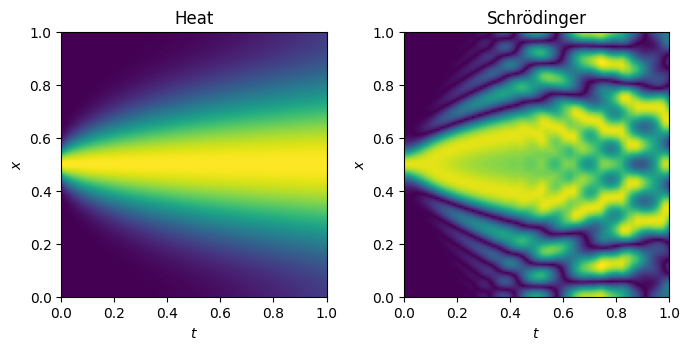

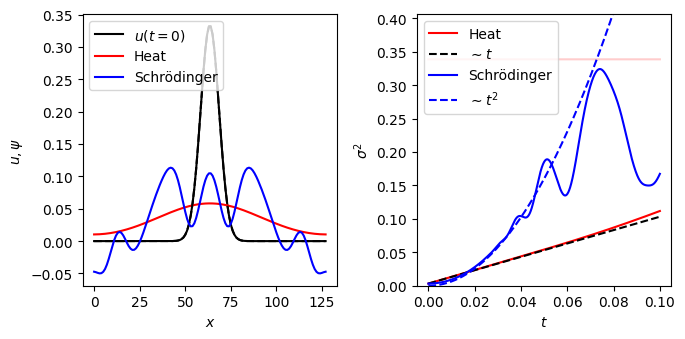

In [110]:
# parameters
nqubits = 7
sigma0 = 0.08
tdim = 50000
tmax = 0.1

# 
tlst = np.linspace(0,tmax,tdim)
xlst = np.linspace(-1,+1,2**nqubits) #[] energy array
f0 = exp(-0.5*((xlst)/(sigma0) )**2)
f0 = f0/sqrt(np.sum(f0**2))

psi_schr = PDEschr(nqubits, tmax, tdim, f0)
psi_heat = PDEheat(nqubits, tmax, tdim, f0)

psi_schr_norm = np.copy(psi_schr)
psi_heat_norm = np.copy(psi_heat)
psi_schr_var = np.zeros(tdim)
psi_heat_var = np.zeros(tdim)
for i in range(tdim):
    psi_schr_norm[i,:] /= np.max(psi_schr_norm[i,:])
    psi_heat_norm[i,:] /= np.max(psi_heat_norm[i,:])
    psi_schr_var[i] = np.sum( xlst**2 * np.abs(psi_schr[i,:])**2 ) / np.sum( np.abs(psi_schr[i,:])**2 )
    psi_heat_var[i] = np.sum( xlst**2 * np.abs(psi_heat[i,:])**2 ) / np.sum( np.abs(psi_heat[i,:])**2 )

figsize = 3.5
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(figsize*2,figsize))
axes[0].imshow( np.abs(np.rot90(psi_heat_norm)), extent=[0,1,0,1] )
axes[1].imshow( np.abs(np.rot90(psi_schr_norm)), extent=[0,1,0,1] )
for i in range(2):
    axes[i].set_xlabel(r'$t$')
    axes[i].set_ylabel(r'$x$')
axes[0].set_title(r'Heat')
axes[1].set_title(r'Schrödinger')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(figsize*2,figsize))
axes[0].plot( psi_heat[0,:], 'k-', label=r'$u(t=0)$' )
axes[0].plot( psi_heat[-1,:], 'r-', label='Heat' )
axes[0].plot( psi_schr[0,:], 'k--' )
axes[0].plot( psi_schr[-1,:], 'b-', label='Schrödinger' )
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$u, \psi$')
axes[0].legend(loc='upper left')

axes[1].plot(tlst, psi_heat_var, 'r-', label='Heat')
axes[1].plot(tlst, 0.5*(sigma0**2 + 2*1*tlst) , 'k--', label=r'$\sim t$')
# maximum allowed variance for the heat equation
unifpsi = xlst*0+1
unifpsi /= np.sqrt( np.sum( np.abs(unifpsi)**2 ) ) 
maxvar = np.sum( xlst**2 * np.abs(unifpsi)**2 ) / np.sum( np.abs(unifpsi)**2 )
axes[1].plot(tlst, tlst*0 + maxvar, 'r-', alpha=0.2)
axes[1].plot(tlst, psi_schr_var, 'b-', label='Schrödinger')
plt.plot(tlst, tlst**2 * 0.5*(2**nqubits), 'b--', label=r'$\sim t^2$')
axes[1].set_xlabel(r'$t$')
axes[1].set_ylabel(r'$\sigma^2$')
axes[1].legend(loc='upper left')
axes[1].set_ylim([0,1.2*maxvar])
plt.tight_layout()
plt.show()